In [2]:
# !apt update
# !apt-get install git-lfs
# !git lfs install
# !mkdir ../vton_origin
# !git clone https://huggingface.co/spaces/yisol/IDM-VTON ../vton_origin
# !rm -rf ../vton_origin/.git/
# !rm -rf ../vton_origin/example/
# !apt-get install rsync
# !rsync -av --ignore-existing vton_origin/ VTO_demo/

In [5]:
# !pip install -r requirements.txt
!nvidia-smi

Sat Sep 21 14:03:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:02:00.0 Off |                  Off |
|  0%   28C    P8             31W /  450W |    7124MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
# !pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121



Looking in indexes: https://download.pytorch.org/whl/cu121

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [22]:
import sys
import cv2
import json
import matplotlib.pyplot as plt
import gradio as gr
from PIL import Image
from src.tryon_pipeline import StableDiffusionXLInpaintPipeline as TryonPipeline
from src.unet_hacked_garmnet import UNet2DConditionModel as UNet2DConditionModel_ref
from src.unet_hacked_tryon import UNet2DConditionModel
from transformers import (
    CLIPImageProcessor,
    CLIPVisionModelWithProjection,
    CLIPTextModel,
    CLIPTextModelWithProjection,
)
from diffusers import DDPMScheduler,AutoencoderKL
from typing import List

import torch
import os
from transformers import AutoTokenizer
import numpy as np
from utils_mask import get_mask_location
from torchvision import transforms
import apply_net
from preprocess.humanparsing.run_parsing import Parsing
from preprocess.openpose.run_openpose import OpenPose
from detectron2.data.detection_utils import convert_PIL_to_numpy,_apply_exif_orientation
from torchvision.transforms.functional import to_pil_image

Im = Image.fromarray
pi = plt.imshow

In [2]:
def pil_to_binary_mask(pil_image, threshold=0):
    np_image = np.array(pil_image)
    grayscale_image = Image.fromarray(np_image).convert("L")
    binary_mask = np.array(grayscale_image) > threshold
    mask = np.zeros(binary_mask.shape, dtype=np.uint8)
    for i in range(binary_mask.shape[0]):
        for j in range(binary_mask.shape[1]):
            if binary_mask[i,j] == True :
                mask[i,j] = 1
    mask = (mask*255).astype(np.uint8)
    output_mask = Image.fromarray(mask)
    return output_mask


device = "cuda" if torch.cuda.is_available() else "cpu"
base_path = 'yisol/IDM-VTON'
example_path = os.path.join('./example')

unet = UNet2DConditionModel.from_pretrained(
    base_path,
    subfolder="unet",
    torch_dtype=torch.float16,
)
unet.requires_grad_(False)
unet.to(device)

tokenizer_one = AutoTokenizer.from_pretrained(
    base_path,
    subfolder="tokenizer",
    revision=None,
    use_fast=False,
)
tokenizer_two = AutoTokenizer.from_pretrained(
    base_path,
    subfolder="tokenizer_2",
    revision=None,
    use_fast=False,
)
noise_scheduler = DDPMScheduler.from_pretrained(base_path, subfolder="scheduler")

text_encoder_one = CLIPTextModel.from_pretrained(
    base_path,
    subfolder="text_encoder",
    torch_dtype=torch.float16,
)
text_encoder_one.to(device)

text_encoder_two = CLIPTextModelWithProjection.from_pretrained(
    base_path,
    subfolder="text_encoder_2",
    torch_dtype=torch.float16,
)

text_encoder_two.to(device)

image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    base_path,
    subfolder="image_encoder",
    torch_dtype=torch.float16,
)
image_encoder.to(device)

vae = AutoencoderKL.from_pretrained(base_path,
                                    subfolder="vae",
                                    torch_dtype=torch.float16,
)
vae.to(device)

# "stabilityai/stable-diffusion-xl-base-1.0",
UNet_Encoder = UNet2DConditionModel_ref.from_pretrained(
    base_path,
    subfolder="unet_encoder",
    torch_dtype=torch.float16,
)

parsing_model = Parsing(0)
openpose_model = OpenPose(0)

UNet_Encoder.requires_grad_(False)
image_encoder.requires_grad_(False)
vae.requires_grad_(False)
unet.requires_grad_(False)
text_encoder_one.requires_grad_(False)
text_encoder_two.requires_grad_(False)
tensor_transfrom = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
    )

pipe = TryonPipeline.from_pretrained(
        base_path,
        unet=unet,
        vae=vae,
        feature_extractor= CLIPImageProcessor(),
        text_encoder = text_encoder_one,
        text_encoder_2 = text_encoder_two,
        tokenizer = tokenizer_one,
        tokenizer_2 = tokenizer_two,
        scheduler = noise_scheduler,
        image_encoder=image_encoder,
        torch_dtype=torch.float16,
)
pipe.unet_encoder = UNet_Encoder

openpose_model.preprocessor.body_estimation.model.to(device)
pipe.to(device)
pipe.unet_encoder.to(device)
print('')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Some weights of the model checkpoint were not used when initializing UNet2DConditionModel: 
 ['add_embedding.linear_1.bias, add_embedding.linear_1.weight, ad

Loading pipeline components...:   0%|          | 0/8 [00:00<?, ?it/s]

In [63]:
from io import BytesIO

In [64]:
person = Image.open('example/human/Screenshot 2024-09-20 at 20.21.32.png')

In [65]:
image_buffer = BytesIO()
person.save(image_buffer, format="PNG")  # You can change the format if needed
image_buffer.seek(0)  # Reset buffer position to the beginning

0

In [66]:
client = Client("http://127.0.0.1:7860/")
blended_image, npy_path, json_path = client.predict(
		image=handle_file(image_buffer),
		model_name="1b",
		api_name="/process_image"
)

Loaded as API: http://127.0.0.1:7860/ ✔


ValueError: File <_io.BytesIO object at 0x7fc5d68b3740> does not exist on local filesystem and is not a valid URL.

In [40]:
classes_segmentation = np.load(npy_path)

with open(json_path, 'r') as f:
    class_mapping = json.load(f)

In [36]:
force_preserve_classes =  ['Hair']
classes_to_preserve_soft = [
    'Apparel',
    'Left_Hand',
    'Left_Lower_Arm',
    'Left_Upper_Arm',
    'Right_Hand',
    'Right_Lower_Arm',
    'Right_Upper_Arm',
    'Torso',
]

clothing_classes = [
    'Upper_Clothing',
    'Lower_Clothing',
]

In [ ]:
preservetion_submask = create_submask(
    segmentation_map=classes_segmentation,
    submask_classes=classes_to_preserve_soft,
    class_mapping=class_mapping
)

force_preservetion_submask = create_submask(
    segmentation_map=classes_segmentation,
    submask_classes=force_preserve_classes,
    class_mapping=class_mapping
)

clothing_submask = create_submask(
    segmentation_map=classes_segmentation,
    submask_classes=clothing_classes,
    class_mapping=class_mapping
)


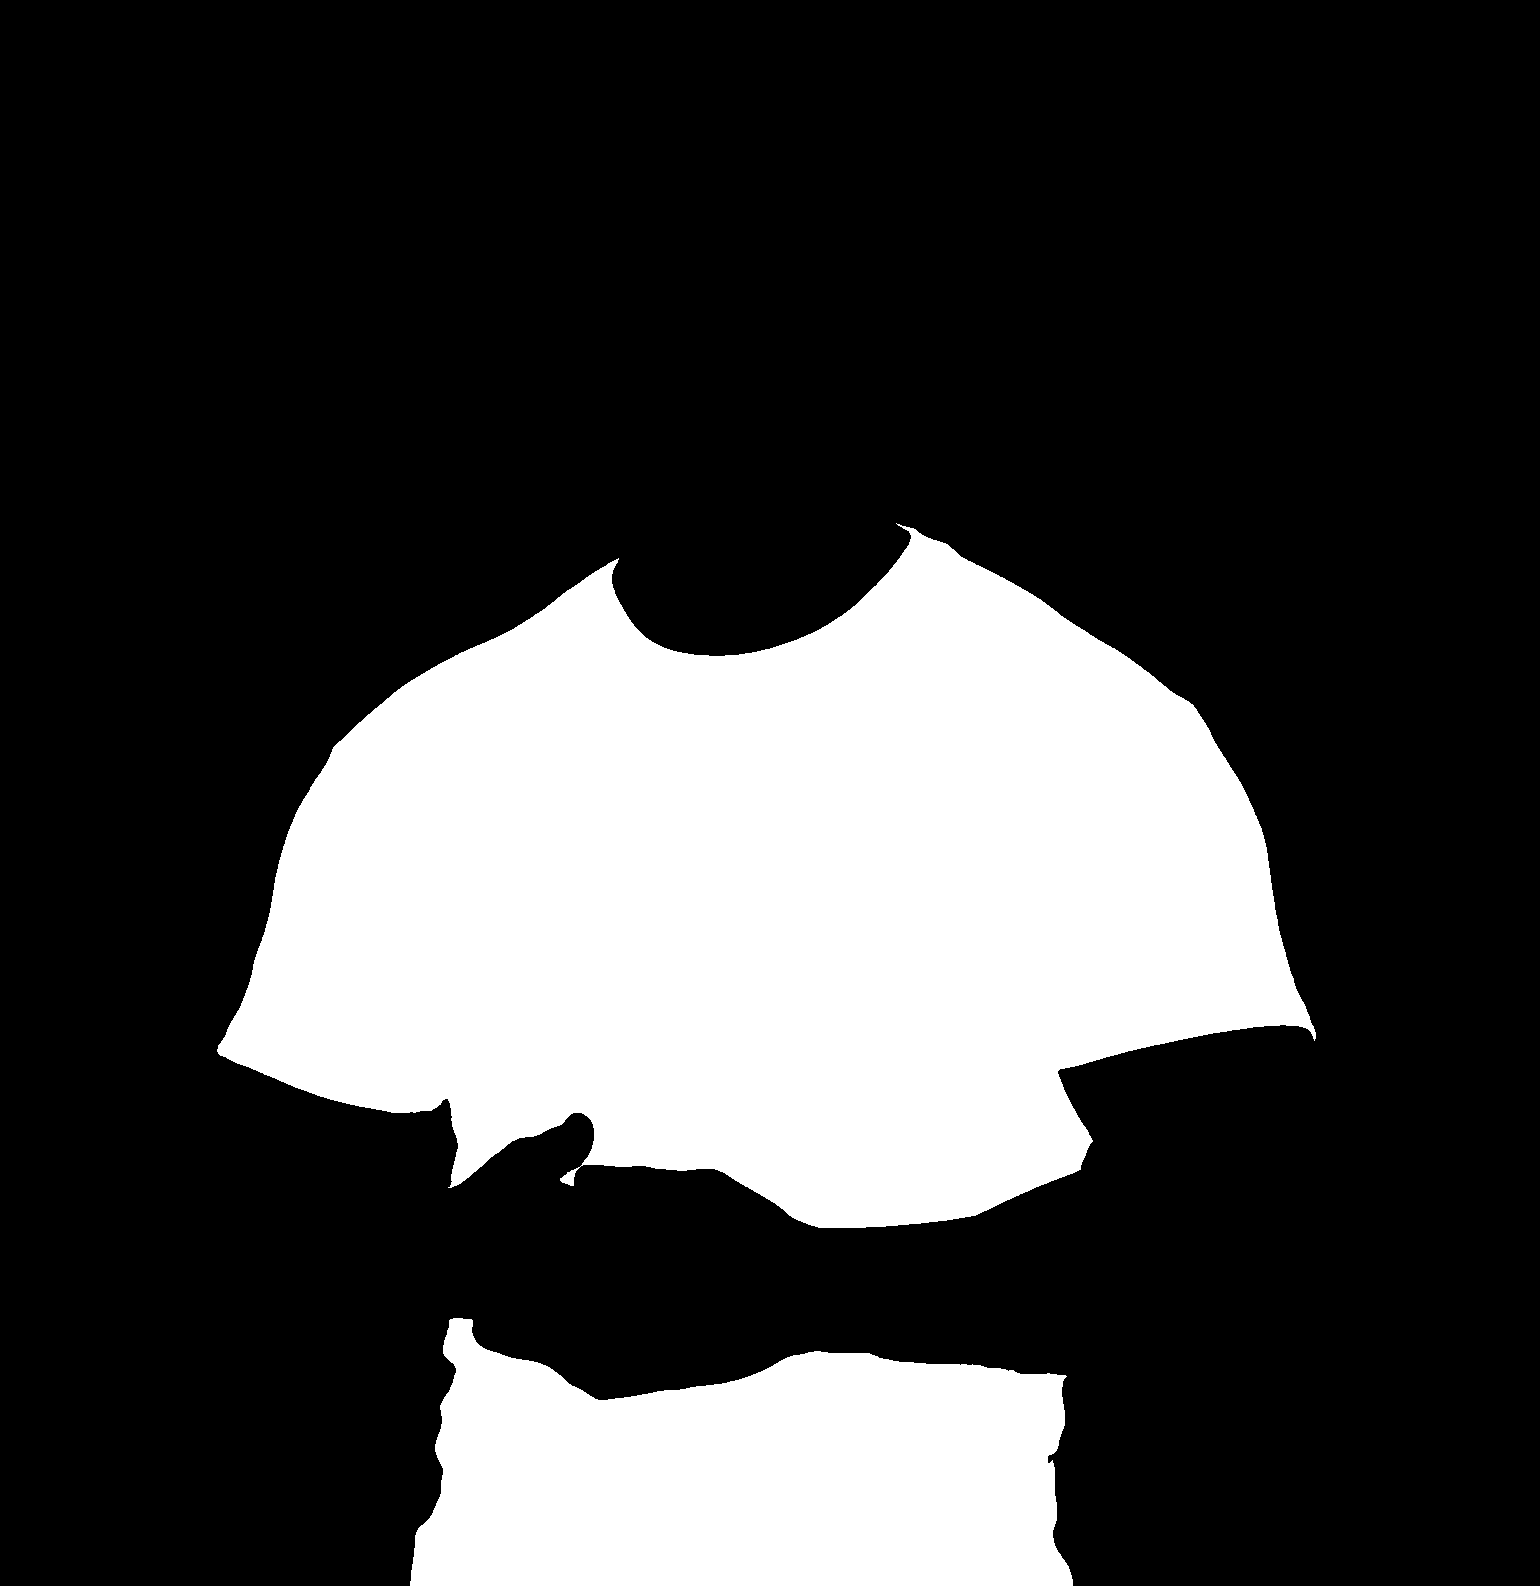

In [52]:
Im(clothing_submask)

In [ ]:
# ~/.cache/huggingface/hub/

In [4]:
human_canva = Image.open('example/human/Screenshot 2024-09-20 at 20.21.32.png')
garm_img = Image.open('example/cloth/14673_00.jpg')
garment_des = "Sleeveless Crew Neck Tank Top in Dark Gray with White 'Guess' Triangle Logo"
denoise_steps = 30
seed = 997

garm_img= garm_img.convert("RGB").resize((768,1024))
human_img_orig = human_canva.convert("RGB")
human_img = human_img_orig.resize((768,1024))


keypoints = openpose_model(human_img.resize((384,512)))
model_parse, _ = parsing_model(human_img.resize((384,512)))
mask, mask_gray = get_mask_location('hd', "upper_body", model_parse, keypoints)
mask = mask.resize((768,1024))

mask_gray = (1-transforms.ToTensor()(mask)) * tensor_transfrom(human_img)
mask_gray = to_pil_image((mask_gray+1.0)/2.0)


human_img_arg = _apply_exif_orientation(human_img.resize((384,512)))
human_img_arg = convert_PIL_to_numpy(human_img_arg, format="BGR")


argument_parser = apply_net.create_argument_parser()
args = argument_parser.parse_args(
    (
        'show',
        './configs/densepose_rcnn_R_50_FPN_s1x.yaml',
        './ckpt/densepose/model_final_162be9.pkl',
        'dp_segm', '-v', '--opts', 'MODEL.DEVICE', 'cuda'
    )
)
pose_img = args.func(args,human_img_arg)
pose_img = pose_img[:,:,::-1]
pose_img = Image.fromarray(pose_img).resize((768,1024))

100%|██████████| 1/1 [00:00<00:00,  3.28it/s]
/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image()
    masks, _, _ = predictor.predict(multimask_output=False)

In [ ]:
with torch.no_grad():
    with torch.cuda.amp.autocast():
        prompt = "model is wearing " + garment_des
        negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"
        with torch.inference_mode():
            (
                prompt_embeds,
                negative_prompt_embeds,
                pooled_prompt_embeds,
                negative_pooled_prompt_embeds,
            ) = pipe.encode_prompt(
                prompt,
                num_images_per_prompt=1,
                do_classifier_free_guidance=True,
                negative_prompt=negative_prompt,
            )

            prompt = "a photo of " + garment_des
            negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"
            if not isinstance(prompt, List):
                prompt = [prompt] * 1
            if not isinstance(negative_prompt, List):
                negative_prompt = [negative_prompt] * 1
            with torch.inference_mode():
                (
                    prompt_embeds_c,
                    _,
                    _,
                    _,
                ) = pipe.encode_prompt(
                    prompt,
                    num_images_per_prompt=1,
                    do_classifier_free_guidance=False,
                    negative_prompt=negative_prompt,
                )



            pose_img =  tensor_transfrom(pose_img).unsqueeze(0).to(device,torch.float16)
            garm_tensor =  tensor_transfrom(garm_img).unsqueeze(0).to(device,torch.float16)
            generator = torch.Generator(device).manual_seed(seed) if seed is not None else None
            images = pipe(
                prompt_embeds=prompt_embeds.to(device,torch.float16),
                negative_prompt_embeds=negative_prompt_embeds.to(device,torch.float16),
                pooled_prompt_embeds=pooled_prompt_embeds.to(device,torch.float16),
                negative_pooled_prompt_embeds=negative_pooled_prompt_embeds.to(device,torch.float16),
                num_inference_steps=denoise_steps,
                generator=generator,
                strength = 1.0,
                pose_img = pose_img.to(device,torch.float16),
                text_embeds_cloth=prompt_embeds_c.to(device,torch.float16),
                cloth = garm_tensor.to(device,torch.float16),
                mask_image=mask,
                image=human_img,
                height=1024,
                width=768,
                ip_adapter_image = garm_img.resize((768,1024)),
                guidance_scale=2.0,
            )[0]

In [12]:
garm_list = os.listdir(os.path.join(example_path,"cloth"))
garm_list_path = [os.path.join(example_path,"cloth",garm) for garm in garm_list]

human_list = os.listdir(os.path.join(example_path,"human"))
human_list_path = [os.path.join(example_path,"human",human) for human in human_list]

human_ex_list = []
for ex_human in human_list_path:
    ex_dict= {}
    ex_dict['background'] = ex_human
    ex_dict['layers'] = None
    ex_dict['composite'] = None
    human_ex_list.append(ex_dict)

##default human


image_blocks = gr.Blocks().queue()
with image_blocks as demo:
    gr.Markdown("## IDM-VTON 👕👔👚")
    gr.Markdown("Virtual Try-on with your image and garment image. Check out the [source codes](https://github.com/yisol/IDM-VTON) and the [model](https://huggingface.co/yisol/IDM-VTON)")
    with gr.Row():
        with gr.Column():
            imgs = gr.ImageEditor(sources='upload', type="pil", label='Human. Mask with pen or use auto-masking', interactive=True)
            with gr.Row():
                is_checked = gr.Checkbox(label="Yes", info="Use auto-generated mask (Takes 5 seconds)",value=True)
            with gr.Row():
                is_checked_crop = gr.Checkbox(label="Yes", info="Use auto-crop & resizing",value=False)

            example = gr.Examples(
                inputs=imgs,
                examples_per_page=10,
                examples=human_ex_list
            )

        with gr.Column():
            garm_img = gr.Image(label="Garment", sources='upload', type="pil")
            with gr.Row(elem_id="prompt-container"):
                with gr.Row():
                    prompt = gr.Textbox(placeholder="Description of garment ex) Short Sleeve Round Neck T-shirts", show_label=False, elem_id="prompt")
            example = gr.Examples(
                inputs=garm_img,
                examples_per_page=8,
                examples=garm_list_path)
        with gr.Column():
            # image_out = gr.Image(label="Output", elem_id="output-img", height=400)
            masked_img = gr.Image(label="Masked image output", elem_id="masked-img",show_share_button=False)
        with gr.Column():
            # image_out = gr.Image(label="Output", elem_id="output-img", height=400)
            image_out = gr.Image(label="Output", elem_id="output-img",show_share_button=False)




    with gr.Column():
        try_button = gr.Button(value="Try-on")
        with gr.Accordion(label="Advanced Settings", open=False):
            with gr.Row():
                denoise_steps = gr.Number(label="Denoising Steps", minimum=20, maximum=100, value=30, step=1)
                seed = gr.Number(label="Seed", minimum=-1, maximum=2147483647, step=1, value=42)



    try_button.click(fn=start_tryon, inputs=[imgs, garm_img, prompt, is_checked,is_checked_crop, denoise_steps, seed], outputs=[image_out,masked_img], api_name='tryon')

image_blocks.launch()

OSError: Cannot find empty port in range: 8038-8038. You can specify a different port by setting the GRADIO_SERVER_PORT environment variable or passing the `server_port` parameter to `launch()`.